In [2]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from functools import wraps
from time import perf_counter

## Zad 1

In [3]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = perf_counter()
        result = func(*args, **kwargs)
        end_time = perf_counter()
        total_time = end_time - start_time
        return result, total_time
    return timeit_wrapper

In [79]:
def get_unity_root(n):
    return np.exp(-2*np.pi*(0 + 1j) / n)

def get_fourier_matrix(n):
    e = get_unity_root(n)
    return np.array([[np.power(e, i*j % n) for i in range(n)] for j in range(n)])

@timeit
def slow_dft(vector, fourier_mat=None):
    n = vector.shape[0]
    if fourier_mat is None:
        fourier_mat = get_fourier_matrix(n)
    return vector @ fourier_mat

def inverse_slow_dft(vector, fourier_mat=None):
    n = vector.shape[0]
    if fourier_mat is None:
        fourier_mat = get_fourier_matrix(n)
    return np.conjugate(fourier_mat @ np.conjugate(vector)) / n


def compute_fft(vector, roots=None):
    if (n := vector.shape[0] // 2) > 0:
        roots = np.exp(1j*np.linspace(0, -np.pi, n + 1)[:-1]) if roots is None else roots
        even = compute_fft(vector[::2], roots[::2])
        odd = compute_fft(vector[1::2], roots[::2])
        return np.hstack((even + roots*odd, even - roots*odd))
    return vector

@timeit
def fast_dft(vector):
    return compute_fft(np.array(vector, dtype=complex))


def inverse_fast_dft(vector):
    n = vector.shape[0]
    return np.conjugate(compute_fft(np.conjugate(vector))) / n

@timeit
def lib_fft(vector):
    return fft(vector)


In [80]:
def get_random_vector(n):
    return np.random.uniform(0, 10, (n, ))


def compare_vectors(v1, v2, eps=1.0e-7):
    n = v1.shape[0]
    if n != v2.shape[0] or not np.allclose(np.abs(v1 - v2), np.zeros(n), rtol=eps):
        raise AssertionError(f"Computed vectors differ, epsilon={eps}")


def test_fourier(n, slow=True):
    vector_sizes = []
    vector_size = 2
    lib_time = []
    slow_time = []
    fast_time = []
    for _ in range(n):
        vector_sizes.append(vector_size)
        vector = get_random_vector(vector_size)
        vector1 = vector
        if slow:
            vector1, t = slow_dft(vector)
            slow_time.append(t)
            vector2 = inverse_slow_dft(vector1)
            compare_vectors(vector, vector2)

        vector3, t = fast_dft(vector)
        fast_time.append(t)
        vector4 = inverse_fast_dft(vector3)
        compare_vectors(vector, vector4)

        vector5, t = lib_fft(vector)
        lib_time.append(t)

        if slow:
            compare_vectors(vector1, vector5)
        compare_vectors(vector3, vector5)

        vector_size <<= 1

    plt.plot(vector_sizes, fast_time, color='red', label='FFT implemented')
    plt.plot(vector_sizes, lib_time, color='blue', label='FFT library')
    if slow:
        plt.plot(vector_sizes, slow_time, color='orange', label='DFT using matrix')

    plt.xlabel('Vectors sizes')
    plt.ylabel('Time[s]')
    plt.legend()
    plt.show()


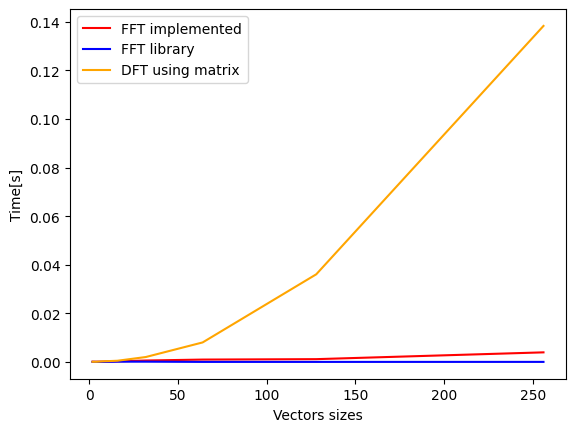

In [81]:
test_fourier(8)

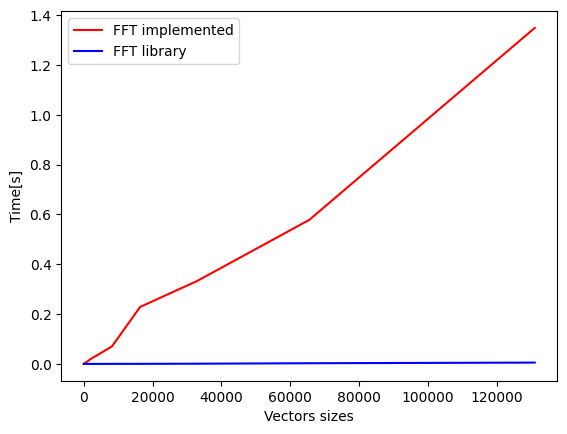

In [82]:
test_fourier(17, slow=False)

## Zad 2

In [11]:
from functools import reduce

def signal(A, f):
    return lambda x: A*np.sin(x*f)

def add_func(f, g):
    return lambda x: f(x) + g(x)

def add_interval(f, g):
    return lambda x: f(x) if x < 8*g[0] else g[1](x)

In [12]:
params = [(1, 2), (2, 5), (5, 3), (6, 1), (4, 4)]

In [13]:
signals = [signal(*param) for param in params]
function1 = reduce(add_func, signals, lambda x: 0)
function2 = reduce(add_interval, enumerate(signals), lambda x: 0)

In [14]:
def plot(x, y, imag=False, abso=False):
    if imag:
        plt.plot(x, np.imag(y), color='orange', label='Imaginary part')
        plt.legend()
    elif abso:
        plt.plot(x, np.abs(y), color='red', label='Magnitudes')
        plt.legend()
    else:
        plt.plot(x, np.real(y))
    plt.show()

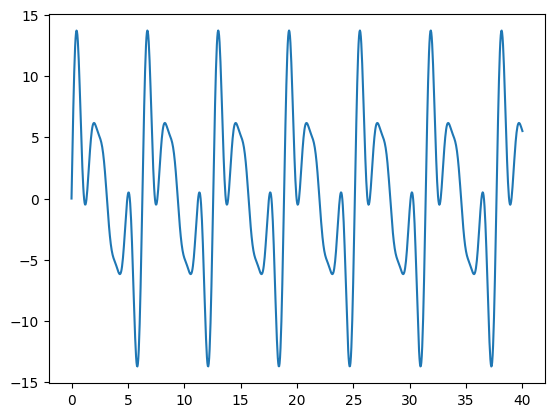

In [15]:
mesh = np.linspace(0, 40, 1000)
values1 = np.vectorize(function1)(mesh)
plot(mesh, values1)

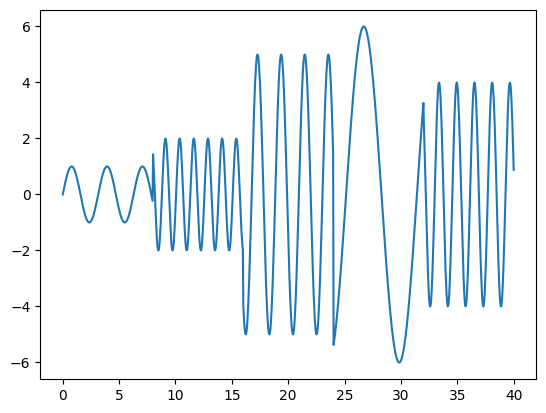

In [16]:
mesh = np.linspace(0, 40, 1000)
values2 = np.vectorize(function2)(mesh)
plot(mesh, values2)

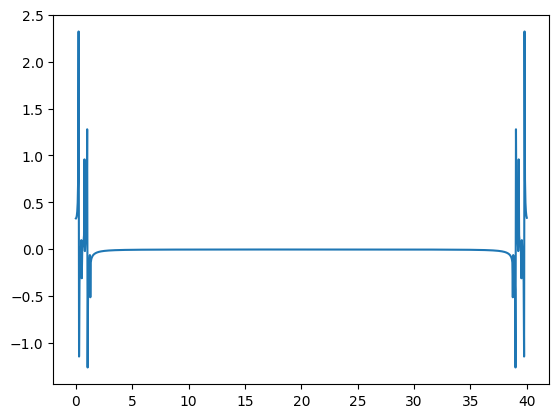

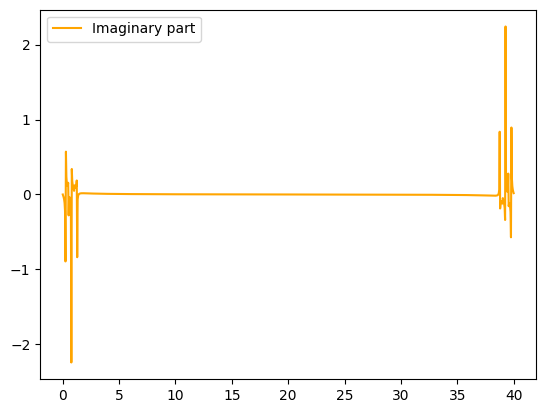

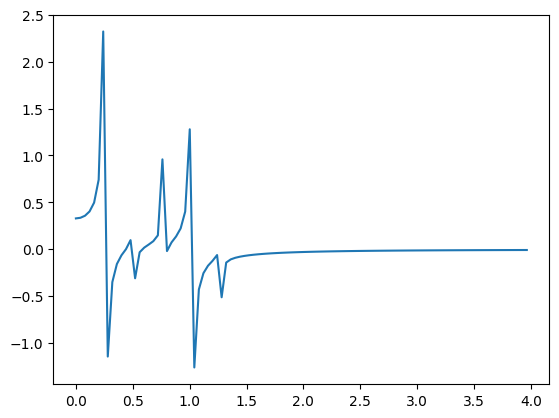

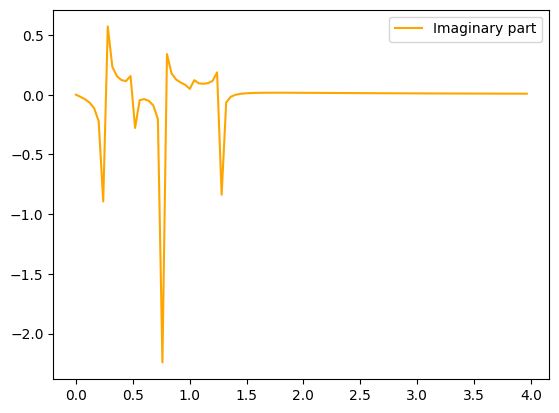

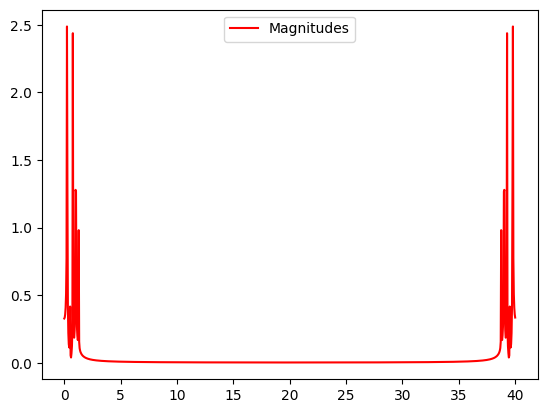

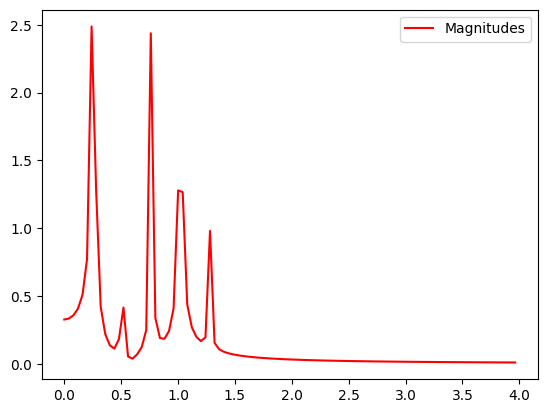

In [17]:
fourier1 = fft(values1) / 1000
plot(mesh, fourier1)
plot(mesh, fourier1, imag=True)
plot(mesh[:100], fourier1[:100])
plot(mesh[:100], fourier1[:100], imag=True)
plot(mesh, fourier1, abso=True)
plot(mesh[:100], fourier1[:100], abso=True)

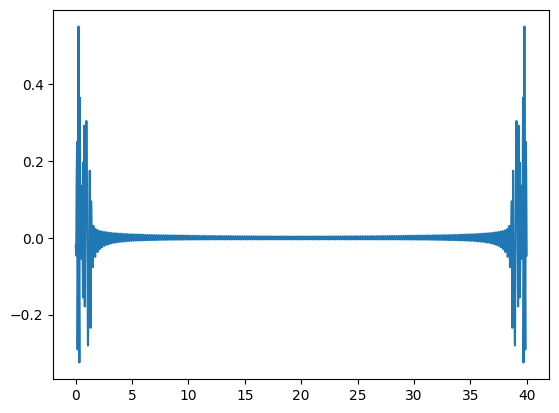

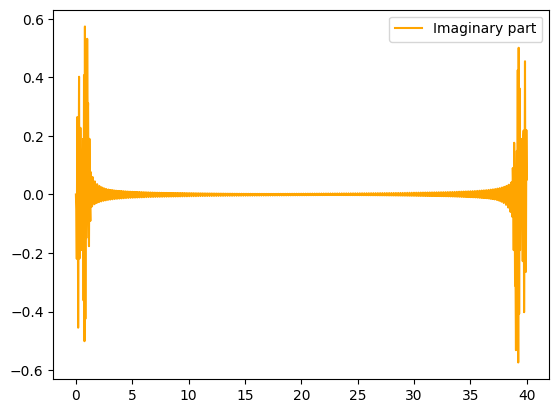

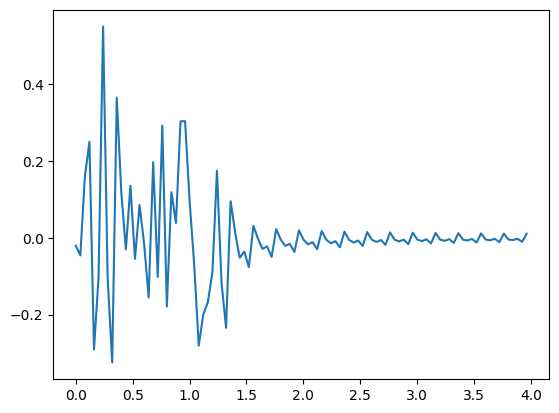

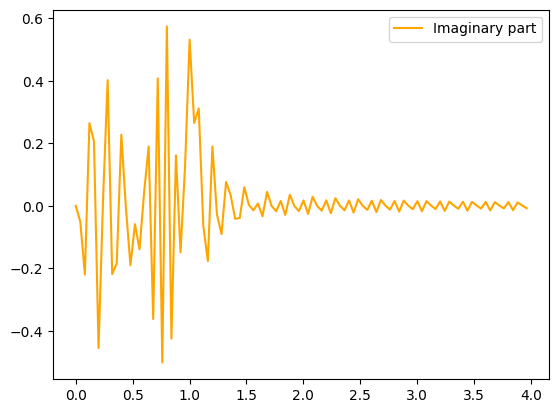

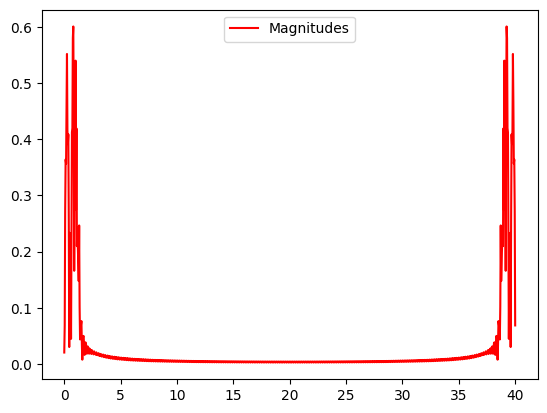

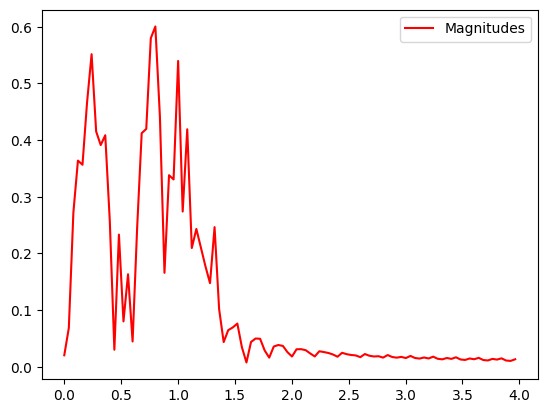

In [18]:
fourier2 = fft(values2) / 1000
plot(mesh, fourier2)
plot(mesh, fourier2, imag=True)
plot(mesh[:100], fourier2[:100])
plot(mesh[:100], fourier2[:100], imag=True)
plot(mesh, fourier2, abso=True)
plot(mesh[:100], fourier2[:100], abso=True)